<a href="https://colab.research.google.com/github/wdoppenberg/mp-operational-envelope/blob/master/OperationalEnvelope.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Delfi-PQ VLM-LPM In-orbit Demonstrator Operational Envelope Analysis**



This notebook is part of the Individual Assignment for the course AE4S07 Micropropulsion, and will analyse the operational envelope of the Delfi-PQ microthruster demonstrator platform. This demonstrator was designed by L. A. Turmaine as part of a thesis, and was done so in accordance with system level requirements set by Delft University of Technology. 

The report starts with the main problem statement, followed by some background information. After this, the current operational envelope reproducibility study is presented, along with the derived optimisation strategies. Finally the implementation of such strategies is given, as well as the effects this has on the demonstrator platform design.


## Research question

Delft University of technology is currently developing and testing two different types of micro-resistojets: the Vaporizing Liquid Micro-resistojet (VLM) and the Low Pressure Micro-resistojet (LPM). The VLM operates by vaporising slightly pressurised liquid water, whereas the LPM is based on the free molecular acceleration of propellant molecules stored at very low pressure. Both of these platforms require in-flight validation, which is the reason why there have been several studies into designing a demonstrator platform which could demonstrate the technology successfully. Considering they both use the same propellant, a single payload unit was designed which could this. Delfi-PQ, Delft University of Technology's latest micro satellite platform, would feature this dual thruster micro-propulsion (DTMP) payload system. 

The main goal of this paper is to validate, optimise, and thoroughly study the draft operational envelope to find the best possible combination of all operational parameters. This is guided by the following research questions:

* **RQ1** What are the input data required to fully characterise the operational envelope, and what are suitable ranges for them?
* **RQ2** Is the current draft operational envelope of the micro-propulsion demonstrator payload the best one in terms of simplicity, completeness and effectiveness of the in-orbit demonstration and, if not, which changes would need to be made to it?


It is important to note that in this study, the current operational envelope is derived from L. A. Turmaine's thesis work [Turmaine]. This paper serves as the guideline for the most current analytical operational envelope, however it does not mean that more recent or otherwise related work was disregarded. 

In [0]:
import numpy as np
import matplotlib.pyplot as plt

# VLM

[[Turmaine, 2018]](https://pdfs.semanticscholar.org/3407/0d83c8b6c77a0f95a16c444f4460dfe5e58c.pdf) 

The method and results presented in [Turmaine] mostly center around the performance profile of the VLM thruster. This makes logical sense because the VLM thruster is fired before the LPM thruster, making the final state of the DTMP after the VLM has finished operations guiding for the performance profile of the LPM. 



## Current state of the demonstrator

The following input variables were found in [Turmaine] and [PALLICHADATH2019414] that allowed for a analytical characterization of the operational envelope of the DTMP. 

| Variable         | Value               | Unit     | Description                                                                         |
|------------------|---------------------|----------|-------------------------------------------------------------------------------------|
| $A_t$            | $$4.5\cdot 10^{-9}$$  | m$^2$    | Nozzle throat area                                                                  |
| $l$              | $0.30$              | $m$      | Propellant tubing length                                                            |
| $R_{water}$      | $461.67$            | J/K/kg   | Gas constant water vapour                                                           |
| $\Gamma_{water}$ | $0.67$              | -        | Van der Kerckhoven constant water vapour                                            |
| $\rho_{water}$   | $997$               | kg/m$^3$ | Density liquid water                                                                |
| $d$              | $1.57\cdot 10^{-3}$ | m        | Inner diameter propellant tubing                                                    |
| $T_0$            | $283$               | K        | Ambient temperature in satellite                                                    |
| $h_{vap}$        | $2256$              | kJ/kg    | Heat of vapourization water vapour                                                  |
| $c_{p,l}$        | $4187$              | J/K/kg   | Specific heat of liquid water                                                       |
| $c_{p,v}$        | $1996$              | J/K/kg   | Specific heat of water vapour                                                       |
| $\Phi_N$         | $0.12$              | -        | Gaseous Nitrogen volume fraction of the initial propellant storage ($\sum\Phi_i=1$) |
| $p_{0,N}$        | $1.1$                 | bar      | Initial Nitrogen pressure                                                           |
| $p_{0,LPM}$      | $2\cdot 10^4$       | Pa       | LPM testing initial inlet pressure                                                  |
| $p_{LPM,req}$    | $270$                 | Pa       | Required pressure in the LPM plenum                                                 |
| $m_0$            | $0.5$                 | g        | Total initial propellant mass                                                       |
| $m_{0,LPM}$      | $0.2$                 | g        | LPM initial propellant mass                                                         |
| $\eta$           | $0.6 $                | -        | Total heating efficiency                                                            |
| $t_{VLM}$        | $1200$                | s        | VLM testing duration                                                                |
| $t_{LPM}$        | $200$                 | s        | LPM testing duration                                                                |

In [0]:
# Temporal components
dt = 0.1        #s
t_end = 1200    #s
t = np.arange(0, t_end, dt, dtype='f')

# Propellant properties
h = 2256e3      #J/kg
c_l = 4187      #J/K/kg liquid water
c_v = 1996      #J/K/kg water vapour
Gamma = 0.6712
R = 461.67      #J/K/kg
rho = 997       #kg/m^3
p_vap0 = 1e5
T_vap0 = 373
h_vap = 40e3
R_vap = 8.341

# Geometric & environmental properties
A_t = 4.5e-9    #m^2 
l = 0.30        #m
d = 1.57e-3     #m
T_0 = 283       #K
V_tube = (l*np.pi*(d**2))/4

# System parameters
p_0 = 1.1e5
T_c0 = h_vap*T_vap0/(T_vap0*R_vap*np.log(p_vap0/p_0)+h_vap)
mdot_0 = p_0*A_t*Gamma/(np.sqrt(R*T_c0))
V_0 = 0.12*V_tube
eff_Q = 0.6

## Method

A combination of Ideal Rocket Theory and the assumption of isothermal expansion led to this method proposed by [Turmaine]. It presents a system of equations that are solved using discrete timesteps, as these are dependent non-linear equations. The source material describes two different methods of simulating the operational envelope, however the one that was chosen regards the chamber temperature $T_c$ as an output that needs to satisfy the vaporisation temperature. 

* Mass flow
$$\dot{m}(t) = \frac{p(t) \cdot A_t \cdot \Gamma}{\sqrt{R \cdot T_C(t)}}$$

* Nitrogen pressure
$$p(t) = \frac{V_0}{V_0 + \frac{m_{\text{exit}}(t)}{\rho_{\text{water}}}} \cdot p_0$$

* Chamber temperature
$$T_C(t) = \frac{T_1 \cdot \Delta h_{\text{vap}}}{T_1 \cdot R \cdot \ln(\frac{p_1}{p(t)}) + \Delta h_{\text{vap}}}$$

Using the given input variables and calculated values for $t_0$ this system is solved for the given testing duration. Using the output of this system, several other performance characteristics of importance can be derived such as thrust, input power, propellant mass, and Nitrogen volume.   


$$ F_T = \dot{m}\cdot I_{sp} \cdot g_0 $$

$$ \dot{Q}(t) = \dot{m}(T_c(t) - T_0)c_{p,l} + h\cdot \dot{m}(t)$$

$$ P_{in}(t) = \frac{\dot{Q}(t)}{\mu} $$ 

$$ m(t) = (V(t) - V_0)\rho_{water} $$

$$ V(t) = V_0 \frac{p_0}{p(t)} $$

## Operational envelope

In [0]:
mdot = np.zeros(t.shape)
p = np.zeros(t.shape)
T_c = np.zeros(t.shape)

mdot[0] = mdot_0
p[0] = p_0
T_c[0] = T_c0
temp = 0

for ii, _ in enumerate(t[1:], 1):
    p[ii] = V_0*p_0/(V_0+temp)
    mdot[ii] = (p[ii-1]*A_t*Gamma) / np.sqrt(R*T_c[ii-1])
    T_c[ii] = h_vap*T_vap0/(T_vap0*R_vap*np.log(p_vap0/p[ii-1])+h_vap)
    temp = temp+mdot[ii-1]*dt/rho

T_vap = h_vap*T_vap0/(T_vap0*R_vap*np.log(p_vap0/p)+h_vap)
Q = mdot * (T_c-T_0)*c_l + h*mdot
V_t = V_0 * (p_0 / p)
m = (V_tube - V_t) * rho

I_sp = 74
g_0 = 9.81
F_T = mdot*I_sp*g_0

Nitrogen pressure 	[2.01e+04, 1.10e+05] Pa
Mass flow 		[1.55e-07, 7.98e-07] kg/s
Thrust 			[1.13e-04, 5.79e-04] N
Chamber temperature 	[3.32e+02, 3.76e+02] K
Propellant mass 	[1.99e-04, 5.10e-04] kg
Input power 		[6.37e-01, 3.52e+00] W


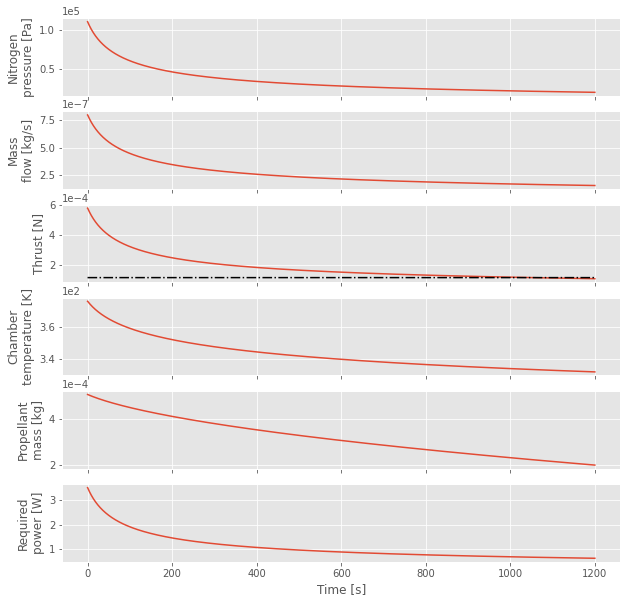

In [0]:
plt.style.use('ggplot')

fig, ax = plt.subplots(6, 1, figsize=(10,10), sharex=True)

ax[0].plot(t, p)
ax[0].set_ylabel('Nitrogen\npressure [Pa]')
ax[0].ticklabel_format(axis="y", style="sci", scilimits=(0,0))
print(f'Nitrogen pressure \t[{min(p):.2e}, {max(p):.2e}] Pa')

ax[1].plot(t, mdot)
ax[1].set_ylabel('Mass\nflow [kg/s]')
ax[1].ticklabel_format(axis="y", style="sci", scilimits=(0,0))
print(f'Mass flow \t\t[{min(mdot):.2e}, {max(mdot):.2e}] kg/s')

ax[2].plot(t, F_T)
ax[2].plot(t, 0.12e-3*np.ones_like(t), 'k-.')
ax[2].set_ylabel('Thrust [N]')
ax[2].ticklabel_format(axis="y", style="sci", scilimits=(0,0))
print(f'Thrust \t\t\t[{min(F_T):.2e}, {max(F_T):.2e}] N')

ax[3].plot(t, T_c)
ax[3].set_ylabel('Chamber\ntemperature [K]')
ax[3].ticklabel_format(axis="y", style="sci", scilimits=(0,0))
print(f'Chamber temperature \t[{min(T_c):.2e}, {max(T_c):.2e}] K')

ax[4].plot(t, m)
ax[4].set_ylabel('Propellant\nmass [kg]')
ax[4].ticklabel_format(axis="y", style="sci", scilimits=(0,0))
print(f'Propellant mass \t[{min(m):.2e}, {max(m):.2e}] kg')

ax[5].plot(t, Q/eff_Q)
ax[5].set_ylabel('Required\npower [W]')
ax[5].ticklabel_format(axis="y", style="sci", scilimits=(0,0))
ax[5].set_xlabel('Time [s]')
print(f'Input power \t\t[{min(Q/eff_Q):.2e}, {max(Q/eff_Q):.2e}] W')

fig.savefig('draft_envelope.pdf')

## Results & validation

| Requirement identifier | Description                                                                                                                                        | Achieved |
|------------------------|----------------------------------------------------------------------------------------------------------------------------------------------------|----------|
| PROP-PERF-200          | The thrust provided by the propulsion system shall be 3 mN as a maximum.                                                                           | X        |
| PROP-PERF-210          | The thrust provided by the propulsion system shall be at least 0.12 mN.                                                                            |    ?      |
| PROP-FUN-100           | The micro-propulsion system shall have at least two modes: idle with max. power consumption 15 mW, and full thrust with max. power consumption 4W. | X        |
| PROP-FUN-200           | The thruster shall be able to operate on gaseous N$_2$, as well as on liquid H$_2$O.                                                                     |          |
| PROP-RAMS-200          | The internal pressure of all propulsion system components shall not be higher than 10 bar.                                                         | X        |

---

In [0]:
requirements = dict(
    PROP_PERF_200=max(F_T) < 3e-3,
    PROP_PERF_210=min(F_T) > 0.12e-3,
    PROP_FUN_100=max(Q/eff_Q) < 4,
    PROP_RAMS_200=max(p) < 10e5
)

print('Not all requirements met.') if False in requirements.values() else print('Requirements met.')
requirements

Not all requirements met.


{'PROP_FUN_100': True,
 'PROP_PERF_200': True,
 'PROP_PERF_210': False,
 'PROP_RAMS_200': True}

As mentioned in [Turmaine], several choices for the operational envelope were made on a rough estimation of the VLM's thrust. **PROP-PERF-200** and more so **PROP-PERF-210** are difficult to validate using the given input variables. In all likelihood however, the minimum thrust of 0.12 mN will not be maintained by the VLM throughout operation, as it barely reaches this level using performance calculations that adhere to all the assumptions of Ideal Rocket Theory (IRT). Losses due to viscous effects, for example, have not been priced in yet. 

With regard to **PROP-FUN-200**: it is decided that the case using liquid water is used as propellant for the current draft operational envelope of the system. 

## Discussion

* [Experimental and Numerical Determination of Micropropulsion
Device Efficiencies at Low Reynolds Numbers](https://engineering.purdue.edu/~alexeenk/papers/aiaaj-05.pdf)
* [Experimental Study of Low
Reynolds Number Nozzles ](https://ntrs.nasa.gov/archive/nasa/casi.ntrs.nasa.gov/19870010950.pdf)

The above operational envelope calculations do not take into account impact of the boundary layer separation caused by low Reynolds numbers which often occur in microthrusters. 

From [[Makhan, 2019]](https://repository.tudelft.nl/islandora/object/uuid%3Aaaed2594-d414-4c83-967b-0cd94cccd23f):

"The nozzle discharge factor relates the experimental mass flow to the theoretical mass flow. It accounts for boundary layer effects and real gas effects (e.g. compressibility). The nozzle quality relates the experimental thrust coefficient to the theoretical thust coefficient. It accounts for losses due to friction effects, divergence and shifting gas composition. [[Suton & Biblarz]](http://mae-nas.eng.usu.edu/MAE_5540_Web/propulsion_systems/subpages/Rocket_Propulsion_Elements.pdf) [[Huzel and Huang]](https://ntrs.nasa.gov/archive/nasa/casi.ntrs.nasa.gov/19710019929.pdf) [[Spisz et al]](https://ntrs.nasa.gov/archive/nasa/casi.ntrs.nasa.gov/19650027295.pdf)."

$$ C_d = \frac{(A_t)_{eff}}{(A_t)_{ideal}} \approx \frac{\dot{m}_{exp}}{\dot{m}_{ideal}} $$

$$ \xi_s = \frac{(I_{sp})_{exp}}{(I_{sp})_{ideal}} $$

An updated version of the operational envelope is created that is supposed to be closer to reality as it takes into account the losses caused by the non-ideal nozzle. Since some time has passed since the first draft operational envelope as presented in [Turmaine], some experimental data has become available that can help with this process.

## Experimental data

The following is derived from a compilation of experimental data for the VLM thruster as found in [Makhan]. It becomes evident that the losses due to low Reynolds numbers are worse than originally found in literature. Be aware that the results found in [Jansen] were performed for the T3$\mu$PS, which is a cold-gas micro-thruster that was part of the DELFI-N3XT mission. 

The data that was recorded from the experiments outlined in [Van Wees] are considered guiding for the purposes of this operational envelope analysis, as it concerns the VLM thruster itself. It has to be noted however, that the uncertainty within these values means that final results cannot be guaranteed to be close to reality, but they do give a close approximation. 

| Data source     | $F$ [mN]  | $$(C_F)_{ideal}$$ [-] | $(C_F)_{exp}$ [-] | $\xi_F$ [-] | $\xi_s$ [-] | $C_d$ [-] | $Re$ [-] |
|-----------------|-----------|---------------------|-------------------|-------------|-------------|-----------|----------|
| Van Wees (2017) | 0.1-0.265 | 1.61                | 0.22-0.33         | 0.2-0.3     | 0.2-0.3     | 0.66-0.68 | 688-1200 |
| Jansen (2016)   | 15.7      | 1.348               | 1.164             | 0.89        | -           | 0.87      | 9968     |

As expected, the lower the Reynolds number, the more prominent the viscous losses are present in the nozzle. This is illustrated by the low discharge coefficient and $I_{sp}$ quality. 

## Corrected current operational envelope

Using the found quality and loss factors, an updated operational envelope that takes into account corrections on Ideal Rocket Theory was calculated. The same method is used as presented in the final draft operational envelope in [Turmaine], using the same input values. However in addition we now have the following system of equations:


* Mass flow
$$\dot{m}(t) = \frac{p(t) \cdot A_t \cdot \Gamma}{\sqrt{R \cdot T_C(t)}} \cdot C_d$$

* Nitrogen pressure
$$p(t) = \frac{V_0}{V_0 + \frac{m_{\text{exit}}(t)}{\rho_{\text{water}}}} \cdot p_0$$

* Chamber temperature
$$T_C(t) = \frac{T_1 \cdot \Delta h_{\text{vap}}}{T_1 \cdot R \cdot \ln(\frac{p_1}{p(t)}) + \Delta h_{\text{vap}}}$$

Using the given input variables and calculated values for $t_0$ this system is solved for the given testing duration. Using the output of this system, several other performance characteristics of importance can be derived such as thrust, input power, propellant mass, and Nitrogen volume.   


$$ F_T = \dot{m}\cdot I_{sp} \cdot g_0 \cdot \xi_s$$

$$ \dot{Q}(t) = \dot{m}(T_c(t) - T_0)c_{p,l} + h\cdot \dot{m}(t)$$

$$ P_{in}(t) = \frac{\dot{Q}(t)}{\mu} $$ 

$$ m(t) = (V(t) - V_0)\rho_{water} $$

$$ V(t) = V_0 \frac{p_0}{p(t)} $$


Using $C_d = \{0.66, 0.87\}$ and $\xi_s = \{0.2, 0.6\}$.

In [0]:
# Temporal components
dt = 0.1        #s
t_end = 1200    #s
t = np.arange(0, t_end, dt, dtype='f')

# Propellant properties
h = 2256e3      #J/kg
c_l = 4187      #J/K/kg liquid water
c_v = 1996      #J/K/kg water vapour
Gamma = 0.6712
R = 461.67      #J/K/kg
rho = 997       #kg/m^3
p_vap0 = 1e5
T_vap0 = 373
h_vap = 40e3
R_vap = 8.341

# Geometric & environmental properties
A_t = 4.5e-9    #m^2 
l = 0.30        #m
d = 1.57e-3     #m
T_0 = 283       #K
V_tube = (l*np.pi*(d**2))/4

# Corrections
C_d_list = np.array([0.66, 0.87])
xi_s_list = np.array([0.2, 0.6])

# Input parameters
p_0 = 1.1e5
T_c0 = h_vap*T_vap0/(T_vap0*R_vap*np.log(p_vap0/p_0)+h_vap)
V_0 = 0.12*V_tube
eff_Q = 0.6

In [0]:
dim = (len(C_d_list), len(t))

mdot =  np.zeros(dim)
p =     np.zeros(dim)
T_c =   np.zeros(dim)
m =     np.zeros(dim)
Q =     np.zeros(dim)
V_t =   np.zeros(dim)
F_T =   np.zeros(dim)
P =     np.zeros(dim)

for i, (C_d, xi_s) in enumerate(zip(C_d_list, xi_s_list)):
    mdot[i, 0] = p_0*A_t*Gamma/(np.sqrt(R*T_c0))*C_d
    p[i, 0] = p_0
    T_c[i, 0] = T_c0
    temp = 0

    for ii, _ in enumerate(t[1:], 1):
        p[i, ii] = V_0*p_0/(V_0+temp)
        mdot[i, ii] = ((p[i, ii-1]*A_t*Gamma) / np.sqrt(R*T_c[i, ii-1]))*C_d
        T_c[i, ii] = h_vap*T_vap0/(T_vap0*R_vap*np.log(p_vap0/p[i, ii-1])+h_vap)
        temp = temp+mdot[i, ii-1]*dt/rho

    T_vap = h_vap*T_vap0/(T_vap0*R_vap*np.log(p_vap0/p)+h_vap)
    Q[i, :] = mdot[i, :] * (T_c[i,:]-T_0)*c_l + h*mdot[i, :]
    P[i, :] = Q[i, :]/eff_Q
    V_t[i, :] = V_0 * (p_0 / p[i, :])
    m[i, :] = (V_tube - V_t[i, :]) * rho

    I_sp = 74*xi_s
    g_0 = 9.81
    F_T[i, :] = mdot[i, :]*I_sp*g_0

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: divide by zero encountered in true_divide


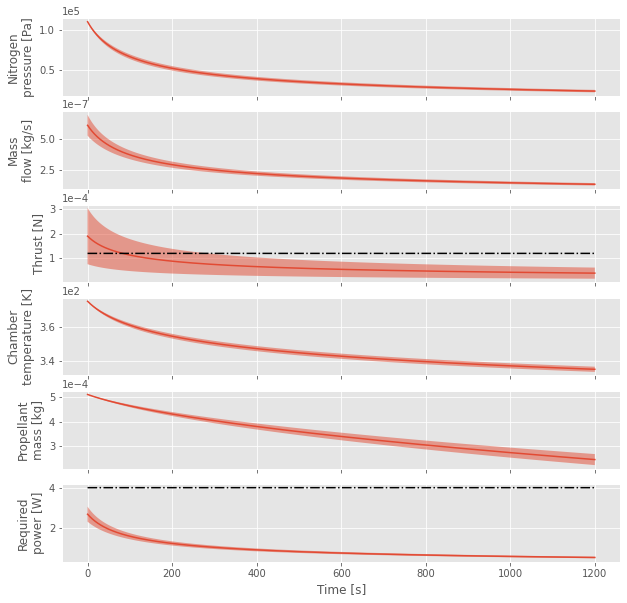

In [0]:
plt.style.use('ggplot')

fig, ax = plt.subplots(6, 1, figsize=(10,10), sharex=True)

ax[0].fill_between(t, p[0, :], p[1, :], alpha=0.5)
ax[0].plot(t, np.mean(p, axis=0))
ax[0].set_ylabel('Nitrogen\npressure [Pa]')
ax[0].ticklabel_format(axis="y", style="sci", scilimits=(0,0))
# print(f'Nitrogen pressure \t[{min(p):.2e}, {max(p):.2e}] Pa')

ax[1].fill_between(t, mdot[0, :], mdot[1, :], alpha=0.5)
ax[1].plot(t, np.mean(mdot, axis=0))
ax[1].set_ylabel('Mass\nflow [kg/s]')
ax[1].ticklabel_format(axis="y", style="sci", scilimits=(0,0))
# print(f'Mass flow \t\t[{min(mdot):.2e}, {max(mdot):.2e}] kg/s')

ax[2].fill_between(t, F_T[0, :], F_T[1, :], alpha=0.5)
ax[2].plot(t, np.mean(F_T, axis=0))
ax[2].plot(t, 0.12e-3*np.ones_like(t), 'k-.')
ax[2].set_ylabel('Thrust [N]')
ax[2].ticklabel_format(axis="y", style="sci", scilimits=(0,0))
# print(f'Thrust \t\t\t[{min(F_T):.2e}, {max(F_T):.2e}] N')

ax[3].fill_between(t, T_c[0, :], T_c[1, :], alpha=0.5)
ax[3].plot(t, np.mean(T_c, axis=0))
ax[3].set_ylabel('Chamber\ntemperature [K]')
ax[3].ticklabel_format(axis="y", style="sci", scilimits=(0,0))
# print(f'Chamber temperature \t[{min(T_c):.2e}, {max(T_c):.2e}] K')

ax[4].fill_between(t, m[0, :], m[1, :], alpha=0.5)
ax[4].plot(t, np.mean(m, axis=0))
ax[4].set_ylabel('Propellant\nmass [kg]')
ax[4].ticklabel_format(axis="y", style="sci", scilimits=(0,0))
# print(f'Propellant mass \t[{min(m):.2e}, {max(m):.2e}] kg')

ax[5].fill_between(t, P[0, :], P[1, :], alpha=0.5)
ax[5].plot(t, np.mean(P, axis=0))
ax[5].plot(t, 4*np.ones_like(t), 'k-.')
ax[5].set_ylabel('Required\npower [W]')
ax[5].ticklabel_format(axis="y", style="sci", scilimits=(0,0))
ax[5].set_xlabel('Time [s]')
# print(f'Required power \t\t[{min(Q):.2e}, {max(Q):.2e}] W')
# print(f'Input power \t\t[{min(Q/eff_Q):.2e}, {max(Q/eff_Q):.2e}] W')

fig.savefig('draft_envelope_corrected.pdf')

In [0]:
requirements = dict(
    PROP_PERF_200=max(F_T[0, :]) < 3e-3,
    PROP_PERF_210=min(F_T[0, :]) > 0.12e-3,
    PROP_FUN_100=max(Q[0, :]/eff_Q) < 4,
    PROP_RAMS_200=max(p[0, :]) < 10e5
)

print('Not all requirements met.') if False in requirements.values() else print('Requirements met.')
requirements

Not all requirements met.


{'PROP_FUN_100': True,
 'PROP_PERF_200': True,
 'PROP_PERF_210': False,
 'PROP_RAMS_200': True}

The expected happens, but it once again confirms the notion that requirement PROP-PERF-210 is not reached. These outcomes were taken into account in the next phase: optimisation.

# Optimised Operational Envelope

In order to decrease the time between design iterations, a object-oriented abstraction was built to efficiently keep track of different setups. This has multiple benefits, the most important of which is a structured approach to designing the DTMP. It automatically executes the steps seen before in the outcomes for the draft operational envelope derived from [Turmaine]. 

The code is hosted in [this GitHub repository](https://github.com/wdoppenberg/mp-operational-envelope), and cloned into the currently active notebook using the following command:

In [0]:
git_url = r"https://github.com/wdoppenberg/mp-operational-envelope"
!git -C c pull || git clone $git_url c

from c.analysis.constants import Water
from c.analysis import OperationalEnvelope, Experiment

fatal: cannot change to 'c': No such file or directory
Cloning into 'c'...
remote: Enumerating objects: 243, done.
remote: Counting objects: 100% (243/243), done.
remote: Compressing objects: 100% (191/191), done.
remote: Total 243 (delta 125), reused 117 (delta 43), pack-reused 0
Receiving objects: 100% (243/243), 2.48 MiB | 6.10 MiB/s, done.
Resolving deltas: 100% (125/125), done.


### Input parameters

At this point it also became important to specify what the exact design input parameters are. Since the design of the VLM nozzle itself is outside of the scope of this project, most of the parameters that can be changed are related to the components outside of the nozzle that can be found in the DTMP. These are:

* $l_{tube}$: The length of the tube that contains the propellant for both thrusters. There is a limit here that is part geometric, meaning the tubing simply won't fit in the demonstrator anymore, and part mass-related, meaning that the mass budget of the demonstrator is exceeded. Furthermore, longer tubing also harbours more risk of leakage. Conversely, smaller tubing would mean there is less propellant for testing, as well as less room for pressurant.

* $d_{tube}$: Similar to $l_{tube}$ this impacts if the tubing would fit, as well as the mass exceeding the set limits. 

* Propellant: For now, only water and Nitrogen have been considered, meaning there are only two sets of propellant characteristics to consider. For convenience, these have been put into a 'dataclass' object found in the repository associated with this project. 

* $p_0$: Initial Nitrogen (pressurant) pressure. This affects the blow-down effect that happens inside the tubing. This is not expected to be orders of magnitudes higher than atmospheric pressure, but as the system will be operating in near-vacuum, it should have the desired effect of moving the propellant towards the heating element and nozzle.

* $\Phi_N$: Initial pressurant fraction. This directly affects the amount of propellant that is inside the tubing. Ofcourse the amount of propellant left for the LPM thruster test needs to be taken into account as well. It also influences how 'smooth' the VLM thrust profile will be throughout operation.

* $t_{end}$: The duration of the operational period of the VLM thruster is also a central variable in the operational envelope, as this can influence the amount of propellant left, and whether the thruster achieves the set requirements during the complete test. 

One important parameter that is not found here is the input power $P_{req}$, but as it has been chosen to change this value in order to satisfy the minimum vaporization temperature, it is an output rather than input parameter. The analysis also allows for a manual input for the values of $C_d$ and $\xi_s$, as these are values that a bound to change after more testing has been done. 


### Performance parameters and goal definition

The performance parameters are derived from the method presented in [Turmaine].

* $p_N(t)$: Initial Nitrogen pressure. 
* $\dot{m}(t)$: Mass flow.
* $F_T(t)$: Thrust.
* $T_c(t)$: Chamber temperature. 
* $m(t)$: Propellant mass (remaining).
* $P(t)$: Required power.

These parameters represent the operational envelope of the thruster, and they are all dependent on the VLM thrust duration $t_{end}$. As per the draft operational envelope [Turmaine], it is desired to have enough propellant remaining for the LPM testing phase. It is decided that $m(t_{end})=0.2$ g, to allow for an LPM testing phase of approximately 200 seconds ($\dot{m}_{LPM} = 1$ mg/s [Turmaine]). This sets a soft requirement on the VLM testing phase. Besides thrust duration, it is important to note that higher thrust is perhaps less desirable than a constant thrust curve. 

Furthermore, the remaining pressure in the tubing is assumed to always be enough for the LPM testing phase, as this is a thruster that is designed to operate at an input pressure as low as 1000 Pa. 

As a goal for the VLM testing phase, it is therefore desirable to have an as long as possible thrust duration while satisfying the set requirements [REQ] and leaving enough resources left for the LPM testing phase.

As a first foray into the optimisation of the DTMP's operational envelope, three cases altering different variables are compared as to quantify what the different effects are on the performance parameters.  

* 1. The current setup (as derived from [Turmaine])
* 2. One with a initial pressure of 2 bar
* 3. One with a larger initial pressurant volume fraction of 0.3. 

Furthermore, the rather dramatic losses caused by the introduction of a very low value for $\xi_s$ has been compared to literature in [van Wees]. The range of values given in [Bayt] at very low Reynolds numbers (0 to 2000) range from 0.77 to 0.98. Given that a value of 0.3 is now used, this seemed like it was rather extreme, therefore the value for $\xi_s$ will be adjusted to 0.6 as a worst-case scenario. 

The following `tests' run for 800 seconds. 

Not all requirements met.
OperationalEnvelope(`1`):
	{'PROP_PERF_200': True, 'PROP_PERF_210': False, 'PROP_FUN_100': True, 'PROP_RAMS_200': True}
            
Not all requirements met.
OperationalEnvelope(`2`):
	{'PROP_PERF_200': True, 'PROP_PERF_210': False, 'PROP_FUN_100': False, 'PROP_RAMS_200': True}
            
Not all requirements met.
OperationalEnvelope(`3`):
	{'PROP_PERF_200': True, 'PROP_PERF_210': False, 'PROP_FUN_100': True, 'PROP_RAMS_200': True}
            


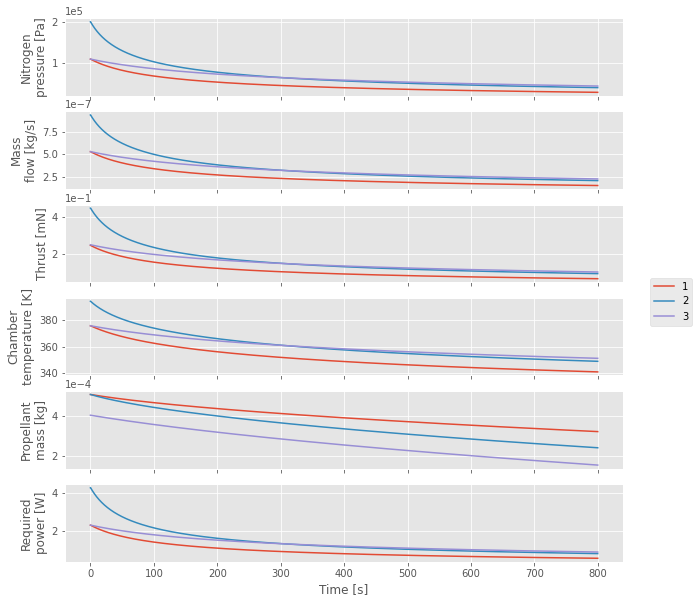

In [0]:
input_vars1 = dict(
    l_tube=0.3,
    d_tube=1.57e-3,
    propellant=Water,
    p_0=1.1e5,
    V_fraction=0.12,
    C_d=0.66,
    xi_s=0.6
)

input_vars2 = dict(
    l_tube=0.3,
    d_tube=1.57e-3,
    propellant=Water,
    p_0=2e5,
    V_fraction=0.12,
    C_d=0.66,
    xi_s=0.6
)

input_vars3 = dict(
    l_tube=0.3,
    d_tube=1.57e-3,
    propellant=Water,
    p_0=1.1e5,
    V_fraction=0.3,
    C_d=0.66,
    xi_s=0.6
)

oe1 = OperationalEnvelope(input_vars1, name='1')
oe2 = OperationalEnvelope(input_vars2, name='2')
oe3 = OperationalEnvelope(input_vars3, name='3')

dt, t_end = 0.1, 800
ex = Experiment(oe1, oe2, oe3)

ex.verification(dt, t_end)
fig = ex.comparison(dt, t_end, return_fig=True)
fig.savefig('foray.pdf')

It becomes apparent that a solution is possible, however it will need to differ from the current draft operational envelope in more ways than just one parameter. 

### Varying initial pressurant volume fraction

Not all requirements met.
OperationalEnvelope(`$V_0=0.1V_{tube}$`):
	{'PROP_PERF_200': True, 'PROP_PERF_210': False, 'PROP_FUN_100': True, 'PROP_RAMS_200': True}
            
Not all requirements met.
OperationalEnvelope(`$V_0=0.2V_{tube}$`):
	{'PROP_PERF_200': True, 'PROP_PERF_210': False, 'PROP_FUN_100': True, 'PROP_RAMS_200': True}
            
Not all requirements met.
OperationalEnvelope(`$V_0=0.3V_{tube}$`):
	{'PROP_PERF_200': True, 'PROP_PERF_210': False, 'PROP_FUN_100': True, 'PROP_RAMS_200': True}
            


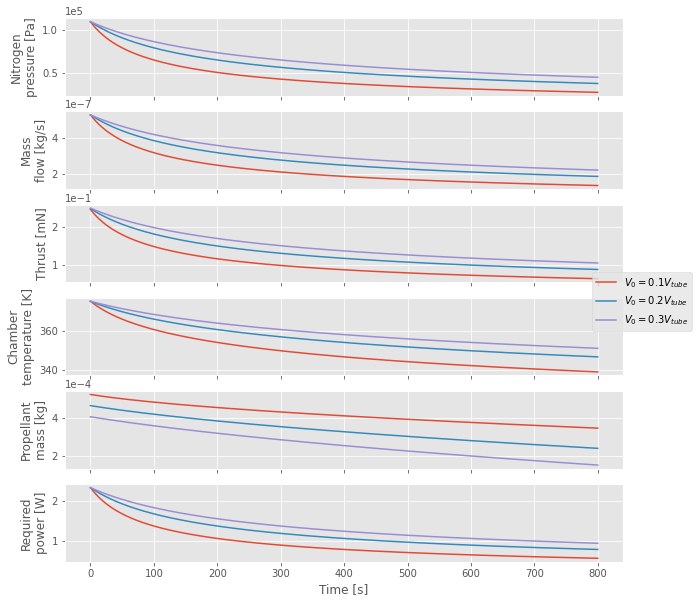

In [0]:
Vf_list =  [0.1, 0.2, 0.3]

input_vars = [
        dict(
            l_tube=0.3,
            d_tube=1.57e-3,
            propellant=Water,
            p_0=1.1e5,
            V_fraction=Vf,
            C_d=0.66,
            xi_s=0.6
        )
        for Vf in Vf_list
    ]

oe_list = [
        OperationalEnvelope(
            i, 
            name=f'$V_0={Vf}V_{{tube}}$'
        ) 
        for i, Vf in zip(input_vars, Vf_list)
    ]
ex = Experiment(*oe_list)
dt, t_end = 0.1, 800
ex.verification(dt, t_end)
fig = ex.comparison(dt, t_end, return_fig=True)
fig.savefig('Vfrac.pdf')

### Varying initial pressure

Not all requirements met.
OperationalEnvelope(`$p_0=1.10e+05$`):
	{'PROP_PERF_200': True, 'PROP_PERF_210': False, 'PROP_FUN_100': True, 'PROP_RAMS_200': True}
            
Not all requirements met.
OperationalEnvelope(`$p_0=1.50e+05$`):
	{'PROP_PERF_200': True, 'PROP_PERF_210': False, 'PROP_FUN_100': True, 'PROP_RAMS_200': True}
            
Not all requirements met.
OperationalEnvelope(`$p_0=2.00e+05$`):
	{'PROP_PERF_200': True, 'PROP_PERF_210': False, 'PROP_FUN_100': False, 'PROP_RAMS_200': True}
            


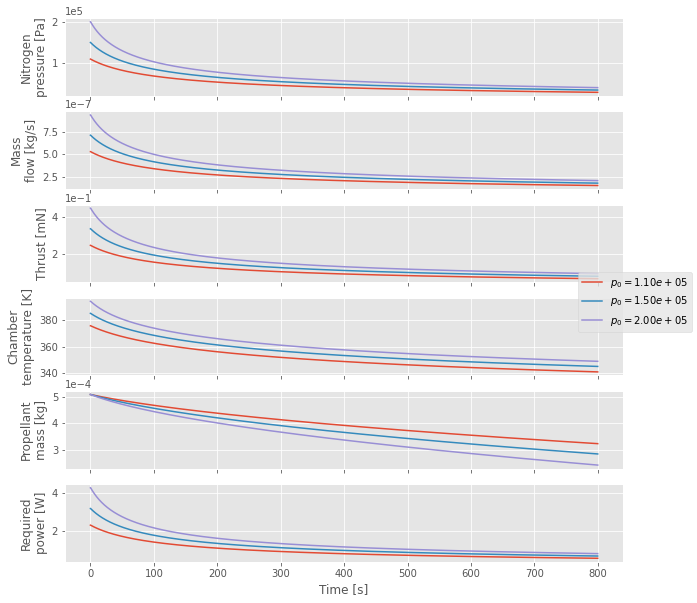

In [0]:
p0_list =  [1.1e5, 1.5e5, 2.0e5]

input_vars = [
        dict(
            l_tube=0.3,
            d_tube=1.57e-3,
            propellant=Water,
            p_0=p_0,
            V_fraction=0.12,
            C_d=0.66,
            xi_s=0.6
        )
        for p_0 in p0_list
    ]

oe_list = [
        OperationalEnvelope(
            i, 
            name=f'$p_0={p_0:.2e}$'
        ) 
        for i, p_0 in zip(input_vars, p0_list)
    ]
ex = Experiment(*oe_list)
dt, t_end = 0.1, 800
ex.verification(dt, t_end)
fig = ex.comparison(dt, t_end, return_fig=True)
fig.savefig('p_in.pdf')

### VLM Final Operational Envelope

It would seem as if a combination of an increase in initial Nitrogen pressure and a larger pressurant volume fraction would have a chance of staying above the minimum required thrust throughout the duration of the test. For the following experiment, the same options for pressurant volume fraction will be taken with a increased starting pressure $p_0$ of 1.8 bar.


            Nitrogen pressure 	[5.08e+04, 1.88e+05] Pa
            Mass flow 		[2.51e-07, 8.80e-07] kg/s
            Thrust 			[1.20e-04, 4.21e-04] N
            Chamber temperature 	[3.54e+02, 3.92e+02] K
            Propellant mass 	[1.52e-04, 4.63e-04] kg
            Required power 		[6.41e-01, 2.39e+00] W
            Input power 		[1.07e+00, 3.98e+00] W
        
Requirements met.
{'PROP_PERF_200': True, 'PROP_PERF_210': True, 'PROP_FUN_100': True, 'PROP_RAMS_200': True}
Propellant left for LPM testing: 0.15g


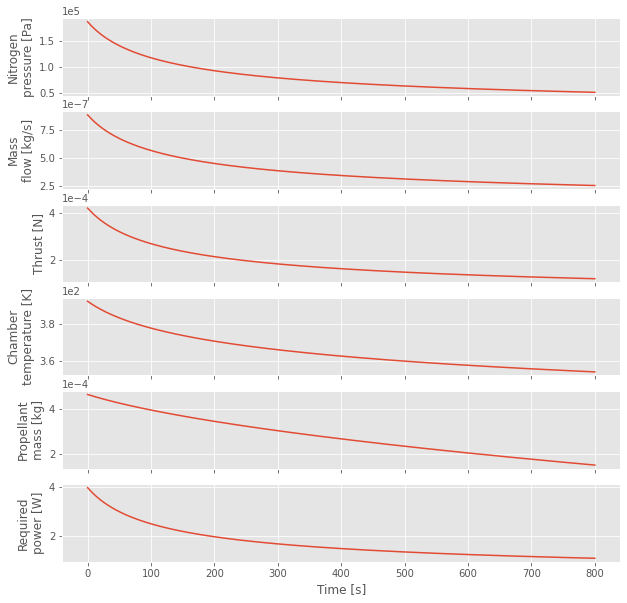

In [0]:
final_input = dict(
        l_tube=0.3,
        d_tube=1.57e-3,
        propellant=Water,
        p_0=1.875e5,
        V_fraction=0.20,
        C_d=0.66,
        xi_s=0.6
    )

final_oe = OperationalEnvelope(
    final_input,
    name=f'FINAL'
)
final_oe.simulate(dt, t_end)
final_oe.describe()
print(final_oe.verify())
fig = final_oe.plot(return_fig=True)
fig.savefig('final.pdf')
print(f'Propellant left for LPM testing: {final_oe.m[-1]*1e3:.2f}g')

# LPM

[[Guerrieri, 2018]](https://pure.tudelft.nl/portal/files/46308497/dissertation.pdf)

## Theoretical background

[Ketsdever et al., 2005] introduce the following analytical model to approximate the performance based on the transitional regime theory.

Mass flow:

$$ \dot{m} = \alpha p_0 \sqrt{\frac{m_a}{2\pi k T_0}}A_e $$

Thrust equation [Guerrieri]
$$ \Im = \alpha p_{0} A_{e} \frac{(\pi+2)}{2 \pi} \sqrt{\frac{T_{w}}{T_{0}}\left(\frac{6 \gamma}{\pi+6 \gamma}\right)} $$



Specific impulse
$$ I_{sp} = \frac{F_T}{\dot{m}g_0} = \sqrt{\frac{\pi k T_w}{2 m g_0^2}} $$

* $P_0$: Plenum pressure
* $m$: Mass of propellant molecules
* $k$: Boltzmann constant
* $T_0$: Plenum temperature
* $T_w$: Heater chip temperature
* $A_e$: Exit area
* $\alpha$: Transmission coefficient | conductance | dimensionless mass flow rate

## Optimisation

It becomes apparent that the design parameters that can be altered that are in the domain of the actual demonstrator platform as opposed to the details of the thruster chip itself, are the plenum pressure $p_0$ and the plenum temperature $T_w$. 

In [0]:
from scipy.constants import physical_constants
import numpy as np
import pandas as pd

k, _, _ = physical_constants['Boltzmann constant']

T_0 = 293.15        # K
alpha = 0.36        # - [Guerrieri]
A_e = 16e-6         # m^2
molmass = 18.015*1e-3/6.022e23 # kg
g_0 = 9.81
c_v = 1996      #J/K/kg water vapour
gamma = 1.33
mass = 150 # mg

In [0]:
p_0 = np.array([50, 150, 300]) # Pa
T_w = np.array([300, 573, 700, 900]) # K

p_0, T_w = np.meshgrid(p_0, T_w, indexing='ij')

mdot = alpha*p_0*np.sqrt(molmass/(2*np.pi*k*T_0))*A_e  # kg/s
F_T =  alpha*p_0*A_e*(np.pi+2)/(2*np.pi)\
            *np.sqrt((T_w/T_0)*(6*gamma)/(np.pi+6*gamma)) # N
I_sp = (np.pi+2)/g_0*np.sqrt(k*T_w*6*gamma/(2*np.pi*molmass*(np.pi+6*gamma))) # s
P = mdot*c_v*(T_w - T_0)/0.6

F_T *= 1e3 # N -> mN
mdot *= 1e6 # kg/s -> mg/s
t_LPM = mass/mdot

results = [
    pd.DataFrame(
        x,
        index=[f"{x} Pa" for x in p_0[:,0]],
        columns=[f"{x} K" for x in T_w[0,:]]
        ) 
    for x in [mdot, F_T, I_sp, P, t_LPM] 
    ]

names = [
         'mdot [mg/s]',
         'F_T [mN]',
         'I_sp [s]',
         'P [W]',
         't [s]'
        ]


pd.options.display.float_format = "{:.2f}".format

for r, n in zip(results, names):
    print(n)
    display(r)

mdot [mg/s]


,300 K,573 K,700 K,900 K
50 Pa,0.31,0.31,0.31,0.31
150 Pa,0.94,0.94,0.94,0.94
300 Pa,1.87,1.87,1.87,1.87


F_T [mN]


,300 K,573 K,700 K,900 K
50 Pa,0.20,0.28,0.31,0.35
150 Pa,0.61,0.84,0.93,1.05
300 Pa,1.21,1.67,1.85,2.10


I_sp [s]


,300 K,573 K,700 K,900 K
50 Pa,65.90,91.08,100.67,114.15
150 Pa,65.90,91.08,100.67,114.15
300 Pa,65.90,91.08,100.67,114.15


P [W]


,300 K,573 K,700 K,900 K
50 Pa,0.01,0.29,0.42,0.63
150 Pa,0.02,0.87,1.27,1.89
300 Pa,0.04,1.74,2.54,3.78


t [s]


,300 K,573 K,700 K,900 K
50 Pa,480.21,480.21,480.21,480.21
150 Pa,160.07,160.07,160.07,160.07
300 Pa,80.03,80.03,80.03,80.03


A favourable setup given in [Guerrieri] specifies that a plenum temperature of 573 K and a plenum pressure of 150 Pa is optimal for the LPM testing phase. The associated performance variables fit the budget that is available in terms of power, available propellant, and thrust force. 

* $\dot{m}$: 0.94 mg/s
* $F_T$: 0.84 mN
* $I_{sp}$: 91.1 s
* $P$: 0.87 W
* $t$: 160 s

In order to facilitate the 150 Pa plenum pressure, a PWM operated valve is used. The scripts required to run this are given in [Ramisa] [Melaika], and would have to take into account a decreasing tank pressure from around 500 millibar and on.

# Conclusion

There are many variables that describe the dual thruster micro-propulsion (DTMP) payload, which is why in this case a model-based approach was taken in order to be capable of quickly iterating through different design choices. The draft operational envelope as given by [Turmaine] was a good starting point, but lacked the conversion factors that map the analytical results to real-world tests. Therefore, the operational envelope was estimated to be too optimistic in terms of performance.

This study incorporates these losses and therefore presents a closer approximation to reality. The main adjustments were to increase the pressurant (Nitrogen) volume fraction in the tubing and to increase the pressure. This resulted in a thrust curve that satisfied the requirements throughout the testing period, at the cost of testing duration. 



## RQ1

*What are the input data required to fully characterize the operational envelope, and what are suitable ranges of values for them?*

As specified in \autoref{VLM} and \autoref{LPM}, a distinction between design parameters at a the DTMP subsystem level and the values that describe the thrusters itself needs to be made. Not doing this would have been detrimental to the design process since there would be too many parameters to oversee at once. With this in mind, the input variables for the complete operational envelope have been given in \autoref{VLMinput} and \autoref{LPMinput}. 

These tables also specify which of the parameters are subject to change in order to meet the requirements imposed on the operational envelope of this demonstrator. This labeling allowed the creation of the analytical model which is used to quickly iterate through designs. 

## RQ2

*Is the current draft operational envelope of the micro-propulsion demonstrator payload the best one in terms of simplicity, completeness and effectiveness of the in-orbit demonstration and, if not, which changes would need to be made to it?*

The demonstrator's operational envelope was drafted at a point in the design process where there was no test data available. Now that such tests have been done, it has become apparent that the losses that hadn't been incorporated in the analytical model before are significantly higher than expected. This meant that, especially for the VLM, the performance requirements would not be met. 

In other words, the setup in terms of simplicity and completeness was good for the purposes of the demonstrator. However the effectiveness would have been lacking, as illustrated by the tests performed on the operational envelope as specified by [Turmaine]. Changes were made to the initial pressurant volume fraction and pressurant pressure, which caused a drop in testing duration, but would ensure that the set performance requirements are reached. 

For further study, it can be interesting to further update the way that the operational envelope can be analytically determined by more advanced simulations. Incorporating such methods into the class objects that form the abstraction for the DTMP payload performance would have the added benefit of maintaining the model-based approach that was set up in this analysis. In more testing-oriented studies it might be more interesting to further verify the proposed setup and to look into the loss factors that were used in the making of the analytical model.

# Appendix: Nozzle quality formulas - VLM

At some point the intention was to use these approximations, however it was deemed out of scope for the goal set in this project. For future projects however, these might be useful. All functions have been verified using [Zandbergen]. 

### Divergence loss

[[Farokhi]](https://www.wiley.com/en-us/Aircraft+Propulsion%2C+2nd+Edition-p-9781118806777)

$$ (C_F)_{div\_loss} = CA \cdot {C_F}^{\circ} + \left( \frac{p_e}{p_a} - \frac{p_a}{p_c} \right)\cdot AR$$

$$ CA_{2D-C} = \frac{\sin(\theta_{nd})}{\theta_{nd}}$$

$$ CA_{3D-C} = \frac{1+\cos(\theta_{nd})}{2}$$ 

* $C_A$: divergence loss factor [-]
* $\theta_{nd}$: nozzle divergence half angle [rad]
* 2D-C: 2D conical nozzle
* 3D-C: 3D conical nozzle


In [0]:
def C_F_divloss(CA, C_F0, p_e, p_a, p_c, AR):
    return CA*C_F0 + (p_e/p_a - p_a/p_c)*AR

def CA_2D(theta_nd):
    return np.sin(theta_nd)/theta_nd

def CA_3D(theta_nd):
    return (1+np.cos(theta_nd))/2

theta_nd = np.radians([10, 15, 20])
1-CA_3D(theta_nd)

array([0.00759612, 0.01703709, 0.03015369])

Verified using p.80 from [Zandbergen]

### Viscous loss

[[Spisz et al]](https://ntrs.nasa.gov/archive/nasa/casi.ntrs.nasa.gov/19650027295.pdf)

$$ (C_F)_{visc\_loss} = (C_F)_{ideal} - (C_F)_{visc} = (C_F)_{ideal} - \frac{17.6\cdot e^{0.0032\cdot AR}}{\sqrt{0.773Re}}$$

In [0]:
def C_F_visc(AR, Re):
    return (17.6 * np.exp(0.0032*AR))/np.sqrt(0.773*Re)

C_F0 = 1
AR = 10
Re = np.logspace(3, 7, 5)

C_F_visc(AR, Re)

array([0.65361249, 0.20669042, 0.06536125, 0.02066904, 0.00653612])

Verified using p. 86 from [Zandbergen]

### Throat boundary layer loss

[[Tang and Fenn]](https://arc.aiaa.org/doi/abs/10.2514/3.60854)

$$ R_{mod} = Re\sqrt{\frac{R^*}{R_t}} $$

$$ (C_d)_{bd\_loss} = 1-\left(\frac{\gamma+1}{2}\right)^{3 / 4}\left\{\frac{72-32 \sqrt{6}}{3(\gamma+1)}+\frac{4 \sqrt{6}}{3}\right\}\left(\frac{1}{\sqrt{R_{m o d}}}\right)+\left(\frac{2 \sqrt{2}(\gamma-1)(\gamma+2)}{3 \sqrt{\gamma+1}}\right)\left(\frac{1}{R_{m o d}}\right) $$


* $R_{mod}$: modified Reynolds number needed to calculate $ (C_d)_{bd\_loss} $
* $R^*$: radius of curvature of nozzle throat section [m]
* $R_t$: radius of nozzle throat [m] 

In [0]:
def R_mod(Re, R_curv, R_t):
    return Re*np.sqrt(R_curv/R_t)

def C_d_bdloss(g, Re, R_curv, R_t):

    A = ((g+1)/2)**(3/4) * ( (72-32*np.sqrt(6))/(3*(g+1)) + (4*np.sqrt(6))/3 )\
            * (1/np.sqrt(R_mod(Re, R_curv, R_t)))
    B = ((2*np.sqrt(2)*(g-1)*(g+2))/(3*np.sqrt(g+1)))*(1/R_mod(Re, R_curv, R_t))

    return 1 - A + B

Re = np.logspace(1, 6, 6)
gamma = 1.2
R_curv = 1
R_t = 1

C_d_bdloss(gamma, Re, R_curv, R_t)

array([0.25988292, 0.75715805, 0.922327  , 0.97534968, 0.99219609,
       0.99753131])

Verified using p.87 from [Zandbergen] (small differences attributed to rounding errors)

## Quality factors

[Zandbergen]

$$ F_{id} = m_{id}\cdot C_{F,id}\cdot c^*_{id} $$
$$ F_{real} = m_{real}\cdot C_{F,real}\cdot c^*_{real} $$

_id_: ideal

Define quality factors denoted with $\xi$:

$$ F_{real} = \xi_{F}F_{id} = C_d m_{id} \cdot \xi_n C_{F,id} \cdot \xi_c c^*_{id} = C_d m_{id} \cdot \xi_s I_{sp,id}$$

* Motor or thrust quality factor:

$$ \xi_F = \frac{F_{real}}{F_{id}} = C_d\xi_n\xi_c $$

* Discharge coefficient:

$$ \frac{m_{real}}{m_{id}} = \frac{C_d}{\xi_c} $$

* Nozzle flow quality:

$$ \xi_n = \frac{C_{F,real}}{C_{F,id}} $$

* Combustion or heating quality:

$$ \xi_c = \frac{c^*_{real}}{c^*_{id}} $$

* $I_{sp}$ or propellant consumption quality:

$$ \xi_s = \frac{I_{sp,real}}{I_{sp,id}} = \xi_n \xi_c $$

## Low throat Reynolds number 

[Zandbergen] p.60-62

Discharge coefficient [Sheshagiri]

$$ C_d = C_{\rho}C_v C_A $$

* Mass flux coefficient

$$ C_{\rho v} = \frac{(\rho v)_{eff}}{(\rho v)_{id}} $$

* Area contraction coefficient 

$$ C_A = \frac{A_{t,eff}}{A_t} $$

## Miscellaneous



$$ \xi_F = \frac{(C_F)_{eff}}{(C_F)_{ideal}} = \frac{F(p_c\cdot A_t)^{-1}}{(C_F)_{ideal}}$$

$$ (C_F)_{ideal} = {C_F}^{\circ}  + \left( \frac{p_e}{p_c} - \frac{p_a}{p_c} \right) \cdot AR = \Gamma \cdot \sqrt{ \frac{2\gamma}{\gamma-1} \cdot \left( 1 - \left( \frac{p_e}{p_c}\right)^{\frac{\gamma-1}{\gamma}} \right)} + \left( \frac{p_e}{p_a} - \frac{p_a}{p_c} \right) \cdot \frac{A_e}{A_t}$$

$$ F = \dot{m}\cdot C_F \cdot c^* $$

$$ {C_F}^{\circ} = \frac{V_e}{c^{*}} $$



$$ \xi_b = \frac{(c^*)_{exp}}{(c^*)_{ideal}} = \frac{\xi_s}{\xi_F} $$

$$ Re = \frac{\dot{m}\cdot D_H}{\mu_t \cdot A_t} $$

$$ D_H = \frac{4A_t}{P_w} $$

$$ \frac{T_t}{T_{tot}} = \frac{\gamma + 1}{2} $$

# LPM theory



## Input variables

| Variable         | Value         | Unit    | Description                      |
|------------------|---------------|---------|----------------------------------|
| $N_{s}$          | $10$          | -       | Number of rectangular slots      |
| $A_s$            | $200*6280$    | $\mu m$ | Slot cross-sectional area        |
| $t_s$            | $500$         | $\mu m$ | Slot thickness in flow direction |
| $p_{transition}$ | $280$         | $Pa$    | Flow regime transition pressure  |
| $Kn$             | $0.1$         | -       | Knudsen number                   |
| $T_c$            | $$[297, 522]$$  | $K$     | Chip operating temperature       |
| $P_c$            | $$[-, 4.4]$$    | $W$     | Power applied to chip            |
| $m$              | $0.2$         | $g$     | Propellant mass                  |
| $p_{in, 0}$      | $2\cdot 10^4$ | $Pa$    | Initial inlet pressure           |
| $f_{PWM}$        | $500$         | $Hz$    | PWM frequency                    |
| $\dot{m}$        | $1$           | $$mg/s$$  | LPM mass flow                    |